## Transformer-based approach to time-series analysis

In this notebook we explore forecasting and classification using 'pure' attentional-based methods (in the sense there is no need for convolution or recurrent connections). The approach is inspired by the one used in [this paper](https://arxiv.org/abs/1706.03762), for good explanations I highly recommend [this visual guide](http://jalammar.github.io/illustrated-transformer/) as well as this [annotated implementation](http://nlp.seas.harvard.edu/2018/04/03/attention.html#encoder-and-decoder-stacks) (from which much of the code here is either directly copied or else cannibalized to suit our application). 

As with the RNN approach, this one is amenable to unsupervised pre-training by training the autoencoder to perform step-ahead forecasting before adjusting the model head and fine-tuning for classification. This is also illustrated in this notebook.

We start by loading and viewing our data:

In [31]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy; import math
import utils
import core
import pdb
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

In [32]:
task = 'StarLightCurves'
df = utils.load_df(task)
df, ts = utils.cleanup(df)

## Architecture

The autoencoder is comprised of a stack of N layers, each consisting of two sublayers: multi-headed attention & position-wise feedforward NN. Each sublayers applies skip connections and [layer normalization](https://arxiv.org/abs/1607.06450). The embedding process consists of a linear layer summed with positional encoding to capture relative temporal interactions.

In [33]:
class AttentionalModel(nn.Module):
    def __init__(self, encoder, decoder, emb):
        super(AttentionalModel,self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.emb = emb
        
    def forward(self, input):
        'Send the input as (src, tgt)'
        src, tgt = input
        return self.decoder(self.emb(tgt), self.encoder(self.emb(src)))

In [34]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [35]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)
    
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory):
        for layer in self.layers:
            x = layer(x, memory)
        return self.norm(x)

In [36]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))


class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x))
        return self.sublayer[1](x, self.feed_forward)

class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, m):
        "Follow Figure 1 (right) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m))
        return self.sublayer[2](x, self.feed_forward)

In [37]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [38]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

In [39]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1, decoder=False, cuda=True):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        self.sub_mask = True if decoder else False
        self.cuda = cuda
    def forward(self, query, key, value):
        "Implements Figure 2"
        if self.sub_mask:
            # Same mask applied to all h heads.
            mask = subsequent_mask(query.size(1)).unsqueeze(1)
            mask = mask.cuda() if query.is_cuda else mask
        else: 
            mask = None
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [40]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [41]:
def make_regressor(in_features=1, n_out=1, N=3, d_model=64, d_ff=128, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model, decoder=False)
    dec_attn = MultiHeadedAttention(h, d_model, decoder=True)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    encoder = Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N)
    decoder = Decoder(DecoderLayer(d_model, c(dec_attn), c(attn), c(ff), dropout), N)
    embs = nn.Sequential(nn.Linear(in_features, d_model), c(position))
    model = nn.Sequential(AttentionalModel(encoder, decoder, embs), nn.Linear(d_model, n_out))
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

In [42]:
class RegressionDataset(Dataset):
    def __init__(self, df, h, cuda=True):
        self.x = torch.Tensor(df[df.columns[:-1]].values)
        self.h = h
        self.cuda = cuda
    def __len__(self):
        return self.x.size(0)
    
    def __getitem__(self, idx):
        src = self.x[idx, :self.h].unsqueeze(1)
        tgt = self.x[idx, self.h:-1].unsqueeze(1)
        src = src.cuda() if self.cuda else src
        tgt = tgt.cuda() if self.cuda else tgt
        y = self.x[idx, self.h+1:].unsqueeze(1)
        y = y.cuda() if self.cuda else y
        x = (src, tgt)
        return x, y
    
class ClassifierDataset(Dataset):
    def __init__(self, df, h, cuda=True):
        self.x = torch.Tensor(df[df.columns[:-1]].values)
        self.h = h
        self.y = torch.Tensor(df.target.values).long()
        self.cuda = cuda
    def __len__(self):
        return self.x.size(0)
    
    def __getitem__(self, idx):
        src = self.x[idx, :self.h].unsqueeze(1)
        tgt = self.x[idx, self.h:-1].unsqueeze(1)
        src = src.cuda() if self.cuda else src
        tgt = tgt.cuda() if self.cuda else tgt
        y = self.y[idx].squeeze()
        y = y.cuda() if self.cuda else y
        x = (src, tgt)
        return x, y

In [43]:
tr_obs = int(0.85 * df.shape[0])
tr_df = df.iloc[:tr_obs]
val_df = df.iloc[tr_obs:]

In [44]:
tr_ds = RegressionDataset(tr_df, h=600)
val_ds = RegressionDataset(val_df, h=600)

In [45]:
tr_dl = DataLoader(tr_ds, batch_size=8, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=8, shuffle=True)
dls = {'train': tr_dl, 'val':val_dl}

In [46]:
model = make_regressor(d_model=64, d_ff=64, N=4).cuda()
crit = nn.MSELoss()
opt = torch.optim.Adam(model.parameters())

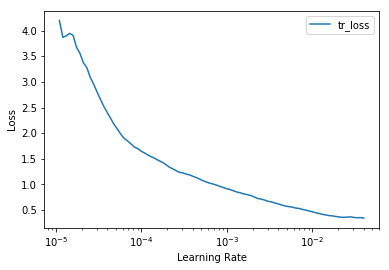

In [48]:
lrf = core.LearningRateFinder(opt, nits=100, min_lr=1e-5, max_lr=1e-1)
lrf.lr_find(model, tr_dl, crit)

In [49]:
max_lr = 1e-3
stepper = core.OneCycle(opt, max_lr=max_lr)

In [50]:
core.fit_regressor(model, stepper, crit, dls, 8)

Epoch 1/8
----------
train Loss: 0.0534
val Loss: 0.0316
Epoch 2/8
----------
train Loss: 0.0363
val Loss: 0.0198
Epoch 3/8
----------
train Loss: 0.0294
val Loss: 0.0154
Epoch 4/8
----------
train Loss: 0.0262
val Loss: 0.0131
Epoch 5/8
----------
train Loss: 0.0245
val Loss: 0.0118
Epoch 6/8
----------
train Loss: 0.0234
val Loss: 0.0112
Epoch 7/8
----------
train Loss: 0.0229
val Loss: 0.0110
Epoch 8/8
----------
train Loss: 0.0228
val Loss: 0.0110
00:02:54


We define a quick helper functions to see how we are getting along...

In [51]:
def fetch_predictions(model, df, ts, h, output=False):
    data = RegressionDataset(df, h=h, cuda=False)
    date_range = [k for k in range(h+1,df.shape[1]-1)]
    dl = DataLoader(data, batch_size=16, shuffle=False)
    pieces = []
    model.cpu()
    model.eval()
    for x,y in dl:
        pieces.append(model(x).detach().numpy())
    preds = pd.DataFrame(np.concatenate(pieces).squeeze())
    preds.index = df.index
    preds = preds.transpose()
    preds['time'] = date_range
    pts = pd.melt(preds, id_vars='time', var_name = 'id', value_name = 'predicted_value')
    pts.id = pts.id.astype('int')
    pts = pd.merge(ts, pts, left_on=['time','id'], right_on=['time', 'id'], how='left').fillna(0)
    return pts

def graph_predictions(pts, size=5):
    ids = np.random.choice(np.arange(pts.id.nunique()), size=size)
    for k in ids:
        piece = pts[pts.id == pts.id.unique()[k]]
        piece.index = piece.time
        fig,ax = plt.subplots()
        piece.value.plot.line()
        piece.predicted_value.plot.line()
        ax.legend()
    return None

In [52]:
pts = fetch_predictions(model, df, ts, 600)

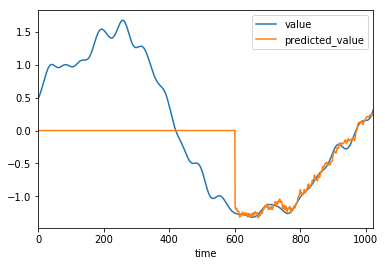

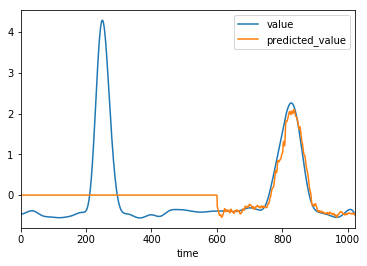

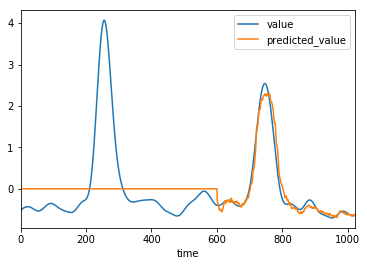

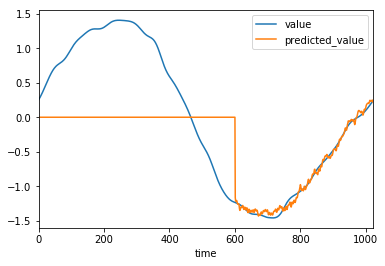

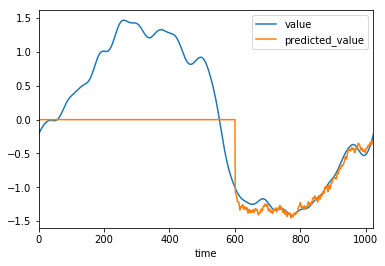

In [53]:
graph_predictions(pts, 5) 

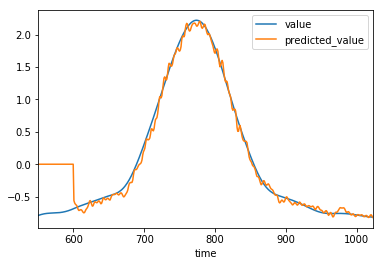

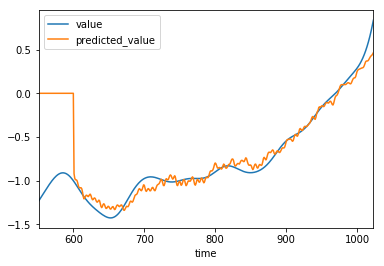

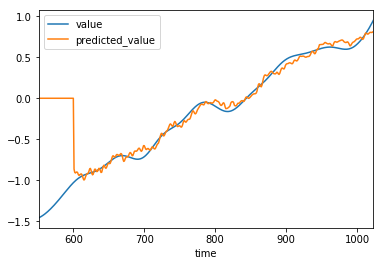

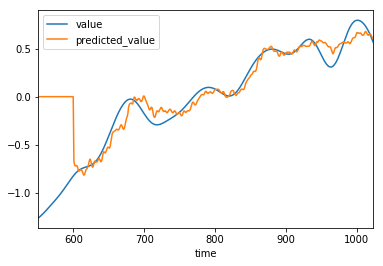

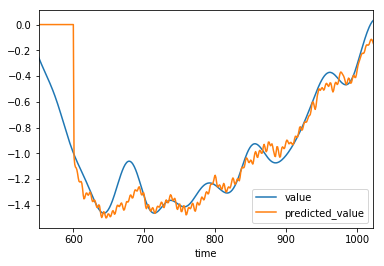

In [54]:
graph_predictions(pts[pts.time > 550], 5)

Now we explore classification with a transformer architecture.

In [14]:
class ClassifierHead(nn.Module):
    def __init__(self, d_model, attn, ff, n_classes, dropout=0.1):
        super(ClassifierHead, self).__init__()
        self.d_model = d_model
        self.attn = attn
        self.ff = ff
        self.out = nn.Linear(d_model, n_classes)
        self.d1 = nn.Dropout(dropout)
        self.d2 = nn.Dropout(dropout)
        self.d3 = nn.Dropout(dropout)
        self.n1 = LayerNorm(d_model)
        self.n2 = LayerNorm(d_model)
              
    def forward(self, x):
        bs = x.size(0)
        query = torch.ones(bs, 1, self.d_model)
        query = query.cuda() if x.is_cuda else query
        x = self.d1(self.n1((self.attn(query, x, x))))
        x = self.d2(self.n2(self.ff(x)))
        x = self.out(self.d3(F.relu(x))).squeeze()
        return x

In [15]:
def make_classifier(in_features=1, n_out=1, N=3, d_model=64, d_ff=128, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model, decoder=False)
    dec_attn = MultiHeadedAttention(h, d_model, decoder=True)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    encoder = Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N)
    decoder = Decoder(DecoderLayer(d_model, c(dec_attn), c(attn), c(ff), dropout), N)
    embs = nn.Sequential(nn.Linear(in_features, d_model), c(position))
    model = (nn.Sequential(AttentionalModel(encoder, decoder, embs), 
                        ClassifierHead(d_model, c(attn), c(ff), n_out, dropout)))
                          
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

In [16]:
class ClassifierDataset(Dataset):
    def __init__(self, df, h, cuda=True):
        self.x = torch.Tensor(df[df.columns[:-1]].values)
        self.h = h
        self.y = torch.Tensor(df.target.values).long()
        self.cuda = cuda
    def __len__(self):
        return self.x.size(0)
    
    def __getitem__(self, idx):
        src = self.x[idx, :self.h].unsqueeze(1)
        tgt = self.x[idx, self.h:-1].unsqueeze(1)
        src = src.cuda() if self.cuda else src
        tgt = tgt.cuda() if self.cuda else tgt
        y = self.y[idx].squeeze()
        y = y.cuda() if self.cuda else y
        x = (src, tgt)
        return x, y

In [17]:
cls_tr_ds = ClassifierDataset(tr_df, h=600)
cls_val_ds = ClassifierDataset(val_df, h=600)

In [18]:
cls_tr_dl = DataLoader(cls_tr_ds, batch_size=8, shuffle=True)
cls_val_dl = DataLoader(cls_val_ds, batch_size=8, shuffle=True)
cls_dls = {'train': cls_tr_dl, 'val':cls_val_dl}

In [27]:
classifier = make_classifier(d_model=64, d_ff=64, h=4, N=4, n_out=3).cuda()
crit = nn.CrossEntropyLoss()
opt = torch.optim.Adam(classifier.parameters())

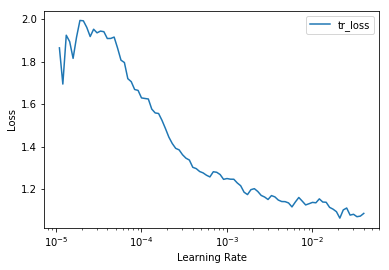

In [28]:
lrf = core.LearningRateFinder(opt, nits=100, min_lr=1e-5, max_lr=1e-1)
lrf.lr_find(classifier, cls_tr_dl, crit)

In [29]:
max_lr = 3e-3
stepper = core.OneCycle(opt, max_lr=max_lr)

In [30]:
core.fit_classifier(classifier, stepper, crit, cls_dls, 3)

Epoch 1/3
----------
train Loss: 0.9940 Acc: 0.5400
val Loss: 0.8456 Acc: 0.6000
Epoch 2/3
----------
train Loss: 0.7176 Acc: 0.7082
val Loss: 0.5298 Acc: 0.8067
Epoch 3/3
----------
train Loss: 0.5270 Acc: 0.8106
val Loss: 0.5211 Acc: 0.8000
00:00:43
